### Imporitng Python Libraries

In [2]:
from charset_normalizer import from_path
import glob
import random

import pandas as pd
import numpy as np
from statistics import mean

import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
from IPython.display import clear_output

import torch
from torch import nn

# Overviewing the dataset and EDA

### Uploading csv file

In [3]:
csv_path = glob.glob("data/*.csv")
print("CSV file path:", csv_path)

best_enc = from_path(csv_path[0]).best().encoding
print("Suggested encoding:", best_enc)

CSV file path: ['data\\Houses.csv']
Suggested encoding: cp1250


In [4]:
house_data = pd.read_csv(csv_path[0], encoding=best_enc)

print("Shape:", house_data.shape, '\n')
house_data.head(3)

Shape: (23764, 11) 



,Unnamed: 0,address,city,floor,id,latitude,longitude,price,rooms,sq,year
0,0,Podgórze Zabłocie Stanisława Klimeckiego,Kraków,2.0,23918.0,50.049224,19.970379,749000.0,3.0,74.05,2021.0
1,1,Praga-Południe Grochowska,Warszawa,3.0,17828.0,52.249775,21.106886,240548.0,1.0,24.38,2021.0
2,2,Krowodrza Czarnowiejska,Kraków,2.0,22784.0,50.066964,19.920025,427000.0,2.0,37.00,1970.0


### Extracting data from Warsaw

In [10]:
wwa_data = house_data[house_data.city == 'Warszawa'].copy()

print("Shape:", wwa_data.shape, '\n')
wwa_data.head(3)

Shape: (9851, 11) 



,Unnamed: 0,address,city,floor,id,latitude,longitude,price,rooms,sq,year
1,1,Praga-Południe Grochowska,Warszawa,3.0,17828.0,52.249775,21.106886,240548.0,1.0,24.38,2021.0
4,4,Ochota Gotowy budynek. Stan deweloperski. Osta...,Warszawa,1.0,11770.0,52.212225,20.972630,996000.0,5.0,105.00,2020.0
7,7,Mokotów Pory,Warszawa,10.0,13308.0,52.184058,21.044302,2890000.0,6.0,280.00,2003.0


### Deleting unnecessary columns

In [11]:
wwa_data = wwa_data.drop(columns=['Unnamed: 0', 'address', 'city', 'id', 'floor'], errors='ignore')
wwa_data.head(1)

,latitude,longitude,price,rooms,sq,year
1,52.249775,21.106886,240548.0,1.0,24.38,2021.0


### Changing the year column to age for better model performance

In [12]:
wwa_data['year'] = 2026.0 - wwa_data['year']
wwa_data.rename(columns={'year': 'age'}, inplace=True)
wwa_data.head(2)

,latitude,longitude,price,rooms,sq,age
1,52.249775,21.106886,240548.0,1.0,24.38,5.0
4,52.212225,20.972630,996000.0,5.0,105.00,6.0


### Creating temporary `price_per_m2` column for trimming and calculating distance to the Warsaw city center 

In [15]:
wwa_data['price_per_m2'] = wwa_data['price'] / wwa_data['sq']

LAT_C, LON_C = 52.2317, 21.0061 # Palace of Culture and Ccience coordinates
d_lat = (wwa_data['latitude'] - LAT_C) * 111.0 # Approximate Latitude conversion for Warsaw
d_lon = (wwa_data['longitude'] - LON_C) * 68.0 # Approximate Longititude conversion for Warsaw

wwa_data['dist_to_center_km'] = np.sqrt(d_lat**2 + d_lon**2)
wwa_data.head(2)

,latitude,longitude,price,rooms,sq,age,price_per_m2,dist_to_center_km
1,52.249775,21.106886,240548.0,1.0,24.38,5.0,9866.611977,7.141049
4,52.212225,20.972630,996000.0,5.0,105.00,6.0,9485.714286,3.138962


In [16]:
wwa_data.describe()

,latitude,longitude,price,rooms,sq,age,price_per_m2,dist_to_center_km
count,9851.000000,9851.000000,9.851000e+03,9851.000000,9851.000000,9851.000000,9851.000000,9851.000000
mean,52.231282,21.005520,7.806199e+05,2.627347,62.704040,29.928738,12244.036499,6.346123
std,0.089208,0.214281,7.063321e+05,1.012861,95.529845,49.625532,4529.248465,16.434526
min,50.492620,4.204796,5.000000e+03,1.000000,8.800000,-954.000000,43.320000,0.051249
25%,52.196098,20.966025,4.650000e+05,2.000000,43.000000,6.000000,9736.009300,3.525824
50%,52.231958,21.010789,5.950000e+05,3.000000,54.300000,18.000000,11520.737327,5.305851
75%,52.251361,21.046546,8.250000e+05,3.000000,70.500000,51.000000,13604.651163,7.857223
max,54.407448,22.632788,1.500000e+07,10.000000,9000.000000,1951.000000,138636.363636,1142.798264


# Preparing Warsaw Dataframe for Linear Regression model
####

### Functions for plotting `wwa_data` columns

In [17]:
def plot_hist(data, col, index):
    plt.subplot(3, 3, index)
    plt.hist(data, bins=100)
    perc_95 = np.percentile(data, 95)
    plt.axvline(perc_95, ls='--', color='red', label=f"Percen. (95): {perc_95:.2f}")
    plt.title(f"Column: {col}")
    plt.legend()

In [18]:
def plot_scatter(df, col_x, index):
    plt.subplot(3, 3, index)
    plt.scatter(x = df[col_x], y = df['price'])
    plt.xlabel(f"{col_x}")

In [19]:
def plot_data(df, plot_type = 'hist'):
    plt.figure(figsize=(12, 6))
    cols = df.columns
    
    for i in range(len(cols)):
        if plot_type == 'hist':
            plot_hist(df[cols[i]], cols[i], i+1)
        else:
            plot_scatter(df, cols[i], i+1)

    plt.tight_layout()
    plt.show()
    plt.close()

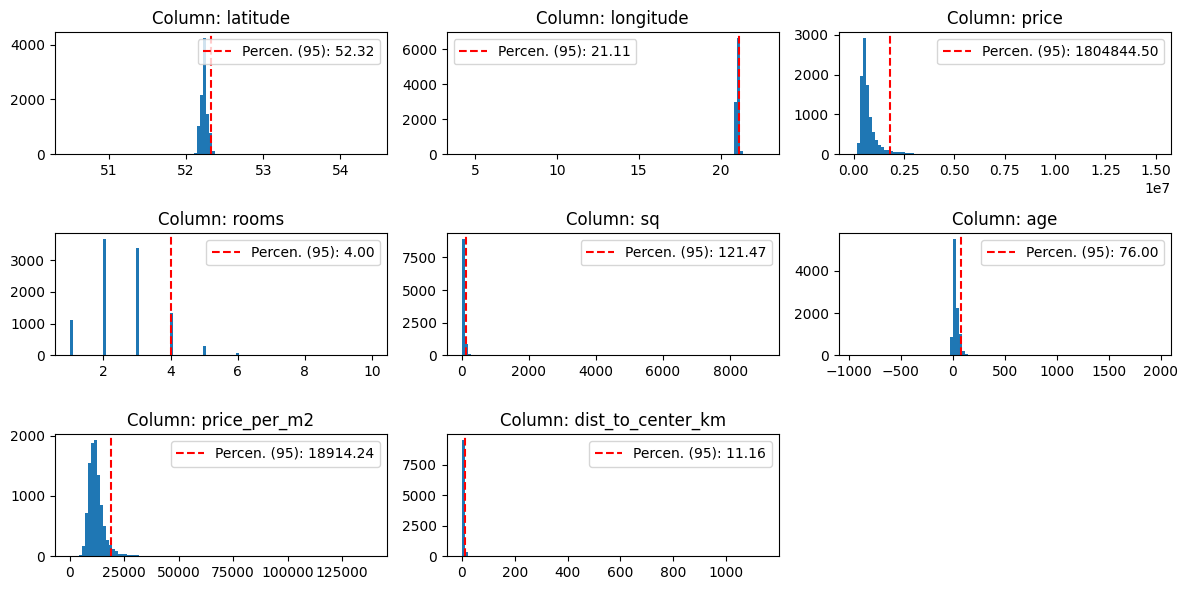

In [20]:
plot_data(wwa_data)

### Trimming Warsaw dataframe

In [21]:
def trim_data(df, col, min_val, max_val):
    return df[(df[col] >= min_val) & (df[col] <= max_val)]

In [23]:
wwa_data = trim_data(wwa_data, 'price', 150000.0, 4000000.0)
wwa_data = trim_data(wwa_data, 'rooms', 1.0, 7.0)
wwa_data = trim_data(wwa_data, 'sq', 25.0, 250.0)
wwa_data = trim_data(wwa_data, 'age', 0.0, 100.0)
wwa_data = trim_data(wwa_data, 'price_per_m2', 6000.0, 35000.0)
wwa_data = trim_data(wwa_data, 'latitude', 52.0, 52.35)
wwa_data = trim_data(wwa_data, 'longitude', 20.0, 21.2)

print(len(wwa_data))

9190


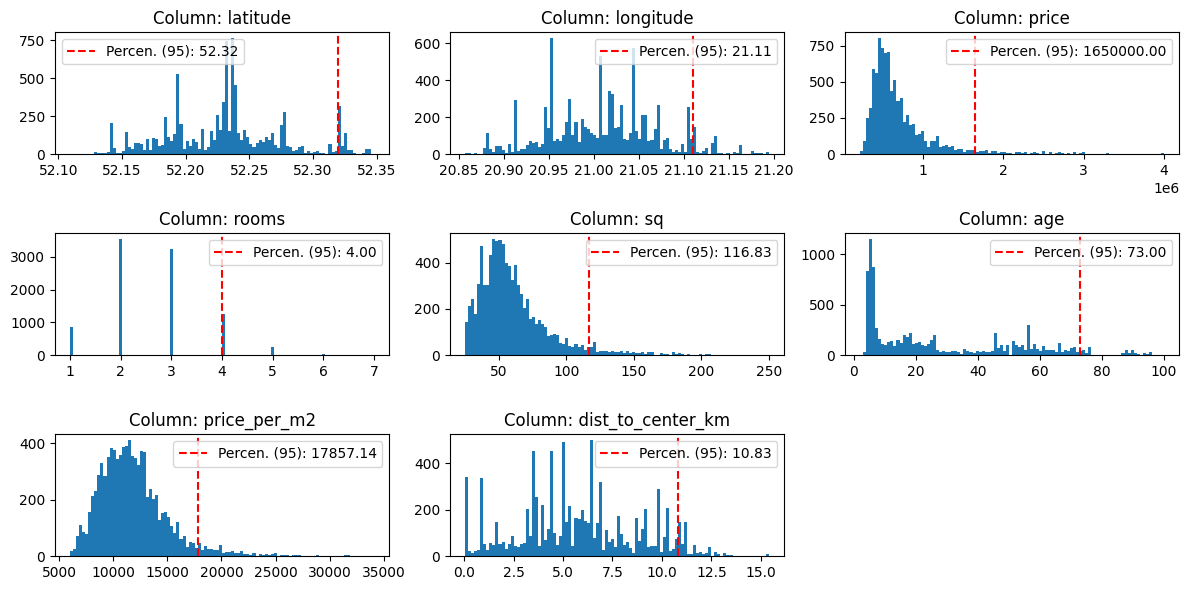

In [24]:
plot_data(wwa_data, 'hist')

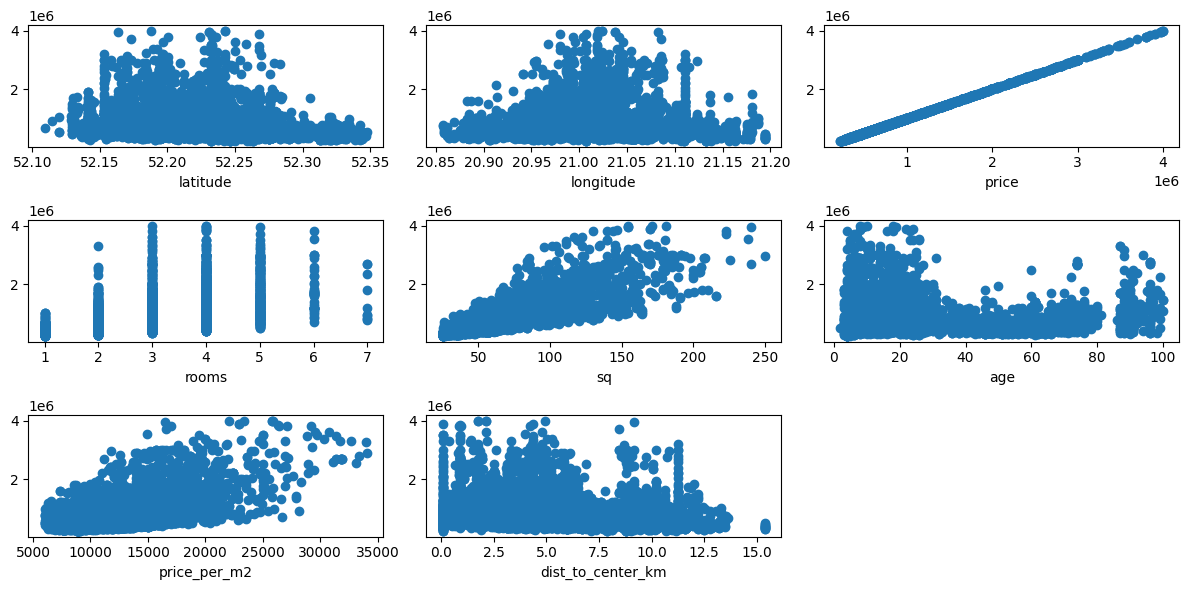

In [25]:
plot_data(wwa_data, 'scatter')

### Deleting unnecessary columns

In [27]:
wwa_data = wwa_data.drop(columns=['price_per_m2', 'rooms', 'latitude', 'longitude'], errors = 'ignore')
print("Shape:", wwa_data.shape, '\n')
wwa_data.describe()

Shape: (9190, 4) 



,price,sq,age,dist_to_center_km
count,9.190000e+03,9190.00000,9190.000000,9190.000000
mean,7.357454e+05,61.07319,27.607943,5.741750
std,4.629332e+05,27.62972,24.753749,3.066625
min,2.230000e+05,25.00000,2.000000,0.051249
25%,4.700000e+05,43.80000,6.000000,3.566317
50%,5.950000e+05,54.39000,18.000000,5.573369
75%,8.113000e+05,70.00000,50.000000,7.857223
max,4.000000e+06,250.00000,100.000000,15.410110


### Shuffling data for proper Linear Regression model performance

In [29]:
wwa_data = wwa_data.sample(frac=1).reset_index(drop=True)

# Linear Regression from Scratch Framework
### Based on d2l object-oriented design
####

## DataModule class
#### - `__init__`: prepares input features and target tensors, applying standardization based on the training split only
#### - Data loader methods create shuffled training batches and sequential validation batches (batch size = 32)

In [42]:
class WwaHousingData():
    def __init__(self, df, num_train=7400, batch_size=32):
        self.num_train = num_train
        self.num_val = len(df) - num_train
        self.batch_size = batch_size
        
        df_y = df[['price']].copy()
        df_X = df[['sq', 'dist_to_center_km', 'age']].copy()
        
        self.y = torch.log(torch.tensor(df_y.values, dtype=torch.float32))
        tensor_X = torch.tensor(df_X.values, dtype=torch.float32)
        
        self.stand_mean = torch.mean(tensor_X[:num_train], dim=0)
        self.stand_std = torch.std(tensor_X[:num_train], dim=0)
        self.X = (tensor_X - self.stand_mean) / self.stand_std

    def get_dataloader(self, train):
        i = slice(0, self.num_train) if train else slice(self.num_train, None)
        return self.get_tensorloader((self.X, self.y), train, i)

    def get_tensorloader(self, tensors, train, indices=slice(0, None)):
        tensors = tuple(a[indices] for a in tensors)
        dataset = torch.utils.data.TensorDataset(*tensors)
        return torch.utils.data.DataLoader(dataset, self.batch_size, shuffle=train)

    def train_dataloader(self):
        return self.get_dataloader(train=True)

    def val_dataloader(self):
        return self.get_dataloader(train=False)

## Model class
#### - `__init__`: initializes learnable weights and bias
#### - forward pass computes linear predictions
#### - loss function implements mean squared error
#### - training and validation steps handle loss computation

In [33]:
class LinearRegressionModel(nn.Module):
    def __init__(self, num_params, l_rate, sigma=0.01):
        super().__init__()
        self.w = torch.normal(mean=0, std=sigma, size=(num_params, 1), requires_grad=True)
        self.b = torch.zeros(1, requires_grad=True)
        self.l_rate = l_rate
        
    def forward(self, X):
        return torch.matmul(X, self.w) + self.b

    def loss(self, y_hat, y):
        l = (y_hat - y) ** 2 / 2
        return l.mean()

    def configure_optimizers(self):
        return SGD([self.w, self.b], self.l_rate)

    def training_step(self, batch):
        l = self.loss(self.forward(batch[0]), batch[-1])
        return l

    def validation_step(self, batch):
        l = self.loss(self.forward(batch[0]), batch[-1])
        return l

## Stochastic Gradient Descent (SGD) class
#### - Implements a simple SGD optimizer
#### - Updates model parameters using computed gradients
#### - Handles gradient reset between optimization steps

In [34]:
class SGD():
    def __init__(self, params, l_rate):
        self.params = params
        self.l_rate = l_rate

    def step(self):
        with torch.no_grad():
            for param in self.params:
                param -= self.l_rate * param.grad

    def zero_grad(self):
        for param in self.params:
            if param.grad is not None:
                param.grad.zero_()

## Trainer class
#### - Manages the training loop and validation loop
#### - Aggregates batch losses into epoch-level metrics
#### - Handles live visualization of training and validation loss

In [43]:
class Trainer():
    def __init__(self, num_epochs, gradient_clip_val=0):
        self.num_epochs = num_epochs
        self.gradient_clip_val = gradient_clip_val

    def prepare_data(self, data):
        self.train_dataloader = data.train_dataloader()
        self.val_dataloader = data.val_dataloader()
        self.num_train_batches = len(self.train_dataloader)
        self.num_val_batches = len(self.val_dataloader)

    def prepare_model(self, model):
        model.trainer = self
        self.model = model

    def fit(self, model, data):
        self.prepare_data(data)
        self.prepare_model(model)
        self.optim = model.configure_optimizers()
        self.epoch = 0
        self.data = data
        self.train_losses_epoch = []
        self.val_losses_epoch = []
        self.init_plot()
        for self.epoch in range(self.num_epochs):
            self.fit_epoch()

    def fit_epoch(self):
        train_losses_batch = []
        val_losses_batch = []
        
        self.model.train()
        for batch in self.train_dataloader:
            loss = self.model.training_step(batch)
            self.optim.zero_grad()
            loss.backward()
            if self.gradient_clip_val > 0: 
                self.clip_gradients(self.gradient_clip_val, self.model)
            self.optim.step()
            train_losses_batch.append(loss.item())

        self.model.eval()
        for batch in self.val_dataloader:
            with torch.no_grad():
                l = self.model.validation_step(batch)
                val_losses_batch.append(l.item())
                
        self.train_losses_epoch.append(mean(train_losses_batch))
        self.val_losses_epoch.append(mean(val_losses_batch))
        self.plot_losses()

    def init_plot(self):
        self.fig, self.ax = plt.subplots(figsize=(8, 5))
        self.ax.set_xlabel("Epoch")
        self.ax.set_ylabel("Loss")
        self.ax.set_title("Training vs Validation Loss")

    def plot_losses(self):
        clear_output(wait=True) 
        epochs = range(1, len(self.train_losses_epoch) + 1)
        plt.figure(figsize=(8,5))
        plt.plot(epochs, self.train_losses_epoch, label=f"Train loss: {self.train_losses_epoch[-1]:.4f}")
        plt.plot(epochs, self.val_losses_epoch, label=f"Val loss: {self.val_losses_epoch[-1]:.4f}")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.title("Training vs Validation Loss")
        plt.legend()
        plt.show()

# Model Initialization and Predicting price

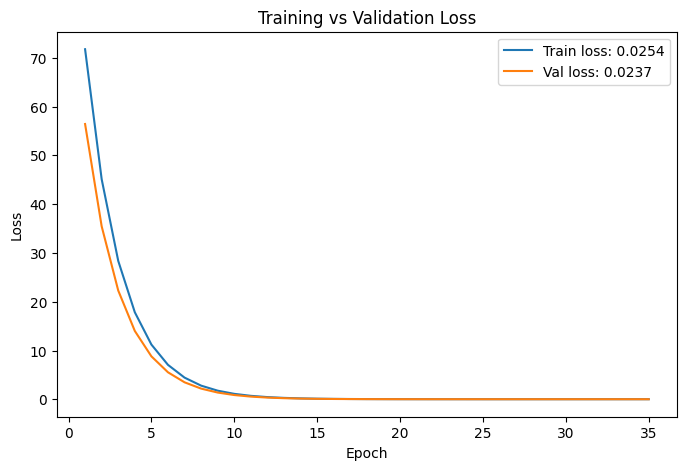

In [37]:
data = WwaHousingData(wwa_data)
model = LinearRegressionModel(3, 0.001)
trainer = Trainer(35)
trainer.fit(model, data)

In [38]:
with torch.no_grad():
    print(model.w, model.b)

tensor([[ 0.3844],
        [-0.1328],
        [-0.0300]], requires_grad=True) tensor([13.3746], requires_grad=True)


### It isn't very accurate model but keep it mind that it's my first proper DL project

In [39]:
def predict_price(sq, dist_km, age, model, data):
    raw_input = torch.tensor([sq, dist_km, age], dtype=torch.float32)
    norm_input = (raw_input - data.stand_mean) / data.stand_std
    model.eval()

    with torch.no_grad():
        log_price = model(norm_input.unsqueeze(0))  
        price_pln = torch.exp(log_price)
    
    print(f"Suggested price: {price_pln.item():,.2f} PLN")

In [41]:
predict_price(30.0, 4.0, 11.0, model, data)

Suggested price: 461,092.59 PLN
